In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%load_ext jupyterlab_notify
%load_ext autoreload
%autoreload 2

pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

In [3]:
from pathlib import Path
import urllib.request
import zipfile
import os
from kaggle.api.kaggle_api_extended import KaggleApi
from kaggle.api_client import ApiClient


def fetch_titanic_dataset():
    titanic_path = "datasets/titanic"
    dataset_path = Path(titanic_path)
    # download dataset
    if not dataset_path.exists():
        api = KaggleApi(ApiClient())
        api.authenticate()
        
        Path("datasets").mkdir(parents=True, exist_ok=True)
        api.competition_download_files("titanic", path="datasets")

        with zipfile.ZipFile(f"{titanic_path}.zip", "r") as zip_file:
            zip_file.extractall(titanic_path)
        
    return pd.read_csv(f"{titanic_path}/train.csv"), pd.read_csv(f"{titanic_path}/test.csv")

In [4]:
train_data, test_data = fetch_titanic_dataset()
train_data = train_data.set_index("PassengerId")
test_data = test_data.set_index("PassengerId")

# Prepare The Data

In [8]:
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

- fill __Embarked__ with "S"
- fill __Age__, __AgeBucket__ using TagName
- fill __Fare__ using Pclass
- Drop __Cabin__

In [9]:
# series_groupby = train_data[["TagName", "AgeBucket", "Embarked"]].groupby("TagName").agg(pd.Series.mode)
def fill_na_(X, series_groupby):
    X = X.copy(deep=True)
    index_colname = series_groupby.index.name
    
    for index_value in series_groupby.index:
        for column_name in series_groupby.columns:
            msk = X[index_colname] == index_value
            fill_val = series_groupby.loc[index_value, column_name]
            X.loc[msk, column_name] = X.loc[msk, column_name].fillna(fill_val)
    return X

In [266]:
def add_tag_name(X, y=None):
    X = X.copy(deep=True)
    unique_tag_names   = ["Don", "Mme",  "Ms",   "Major", "Lady", "Sir", "Mlle", "Col", "Capt", "the Countess", "Jonkheer", "Dona"]
    replaces_tag_names = ["Mr",  "Miss", "Miss", "Mr",    "Miss", "Mr",  "Miss", "Mr",  "Mr",   "Mrs",          "Mr", "Miss"]
    X["TagName"] = X["Name"].apply(lambda x :  x[x.find(',')+2: x.find('.')])
    X["TagName"] = X["TagName"].replace(dict(zip(unique_tag_names, replaces_tag_names)))
    return X


def add_age_bucket(X, y=None):
    X = X.copy(deep=True)
    X["AgeBucket"] = pd.qcut(train_data["Age"], 10, )
    return X

def add_relatives_count(X, y=None):
    X = X.copy(deep=True)
    X["RelativesCount"] = X["SibSp"] + X["Parch"]
    return X

In [267]:
class TitanicImputer(BaseEstimator, TransformerMixin):
    def __init__(self, add_age_bucket = False):
        self.add_age_bucket = add_age_bucket
        
    def fit(self, X, y=None):
        # print(X)
        self.fare_fill = X[["Pclass", "Fare"]].groupby("Fare").median()
        if self.add_age_bucket:
            self.age_bucket_fill = X[["TagName", "AgeBucket"]].groupby("TagName").agg(lambda x : x.value_counts().idxmax())
        else:
            self.age_fill = X[["TagName", "Age"]].groupby("TagName").median()
        
        return self

    def transform(self, X):
        X = X.copy(deep=True)
        X["Embarked"] = X["Embarked"].fillna("S")

        X = fill_na_(X, self.fare_fill)
        
        if self.add_age_bucket:
            X = fill_na_(X, self.age_bucket_fill)
        else:
            X = fill_na_(X, self.age_fill)
            
        return X



In [268]:
cat_columns = ['Pclass', 'TagName', 'Sex', 'Embarked'] #, 'AgeBucket']
num_columns = ['SibSp', 'Parch', 'RelativesCount'] #, 'Age']

# Add AgeBucket => for numerical clf
pipeline_bucket_base = Pipeline([
    ('add_tag_name', FunctionTransformer(add_tag_name)),
    ('add_age_bucket', FunctionTransformer(add_age_bucket)),
    ('add_relatives_count', FunctionTransformer(add_relatives_count)),
    ('custom_bucket_imputer', TitanicImputer(add_age_bucket=True)),
    ('col_tranform', 
        ColumnTransformer([
            ('num_pipeline', StandardScaler(), num_columns),
            ('cat_bucket_pipeline', OneHotEncoder(sparse_output=False), cat_columns + ['AgeBucket']),
        ])
    )
    
])

# No AgeBucket => for tree classifiers
pipeline_nobucket_base = Pipeline([
    ('add_tag_name', FunctionTransformer(add_tag_name)),
    ('add_relatives_count', FunctionTransformer(add_relatives_count)),
    ('custom_bucket_imputer', TitanicImputer(add_age_bucket=False)),
    ('col_tranform', 
         ColumnTransformer([
            ('num_pipeline', StandardScaler(), num_columns + ['Age']),
            ('cat_pipeline', OneHotEncoder(sparse_output=False), cat_columns),
        ])
    )
])

In [269]:
pipeline_nobucket_base.fit_transform(train_data).shape

(891, 18)

- "TagName" => 6
- "Sex" => 2
- "Embarked" => 3
- "Pclass" => 3
- "SibSp" => 1
- "Parch" => 1
- "RelativesCount" => 1
- "Age" => 1

In [270]:
pipeline_bucket_base.fit_transform(train_data).shape

(891, 27)

- "TagName" => 6
- "Sex" => 2
- "Embarked" => 3
- "Pclass" => 3
- "SibSp" => 1
- "Parch" => 1
- "AgeBucket" => 10

In [271]:
from sklearn.model_selection import train_test_split

In [272]:
X, y = train_data.drop(['Survived'], axis=1), train_data["Survived"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

print(y_train.shape, y_test.shape)

(801,) (90,)


In [273]:
X_train_nobucket = pipeline_nobucket_base.fit_transform(X_train)
X_test_nobucket = pipeline_nobucket_base.transform(X_test)

X_train_bucket = pipeline_bucket_base.fit_transform(X_train)
X_test_bucket  = pipeline_bucket_base.transform(X_test)

print(X_train_nobucket.shape, X_test_nobucket.shape)
print(X_train_bucket.shape, X_test_bucket.shape)

(801, 18) (90, 18)
(801, 27) (90, 27)


In [275]:
X_submit_nobucket = pipeline_nobucket_base.transform(test_data)
X_submit_bucket = pipeline_bucket_base.transform(test_data)

# Shortlist Promising Models

In [94]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

In [95]:
from sklearn.model_selection import cross_validate, cross_val_predict, cross_val_score, GridSearchCV

In [96]:
models = [RandomForestClassifier(), AdaBoostClassifier(), GradientBoostingClassifier(), XGBClassifier(), LogisticRegression(), SVC(), GaussianNB(), KNeighborsClassifier(), MLPClassifier()]
models_names = ["clf_forest", "clf_adaboost", "clf_gb", "clf_xgb", "clf_logistic", "clf_svc", "clf_bayes", "clf_knn", "clf_nn"]


In [97]:
import time

In [113]:
cv_scores = {}

for include_bucket in range(2):
    for i, model in enumerate(models):
        model_name = models_names[i] if not include_bucket else models_names[i] + "_bucket"
        X_ = X_train_nobucket if not include_bucket else X_train_bucket
        
        tick = time.time()
        print(f"=====\t Start {model_name} \t=====")
        
        cv_scores[model_name] = cross_val_score(model, X_, y_train, cv = 10, scoring="accuracy")
        
        print(cv_scores[model_name])
        print(f"=====\t time taken:\t {time.time() - tick}sec \t=====")

=====	 Start clf_forest 	=====
[0.81481481 0.7875     0.8        0.8        0.8625     0.7875
 0.75       0.7625     0.825      0.7875    ]
=====	 time taken:	 1.4264240264892578sec 	=====
=====	 Start clf_adaboost 	=====


C:\Users\asusr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\asusr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\asusr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\asusr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is 

[0.81481481 0.8625     0.8125     0.85       0.8625     0.825
 0.7625     0.725      0.825      0.825     ]
=====	 time taken:	 0.8020248413085938sec 	=====
=====	 Start clf_gb 	=====
[0.81481481 0.85       0.85       0.875      0.85       0.8375
 0.775      0.775      0.8625     0.8375    ]
=====	 time taken:	 1.1757838726043701sec 	=====
=====	 Start clf_xgb 	=====
[0.79012346 0.8125     0.825      0.85       0.8625     0.8
 0.7875     0.7875     0.8375     0.8375    ]
=====	 time taken:	 0.4324963092803955sec 	=====
=====	 Start clf_logistic 	=====
[0.83950617 0.85       0.8125     0.9        0.85       0.85
 0.725      0.725      0.85       0.8625    ]
=====	 time taken:	 0.15792226791381836sec 	=====
=====	 Start clf_svc 	=====
[0.83950617 0.85       0.8375     0.8875     0.85       0.8375
 0.7875     0.7125     0.8375     0.8125    ]
=====	 time taken:	 0.15697288513183594sec 	=====
=====	 Start clf_bayes 	=====
[0.56790123 0.4375     0.4625     0.4625     0.45       0.4
 0.5    

C:\Users\asusr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\asusr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\asusr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\asusr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

[0.81481481 0.85       0.8375     0.9125     0.85       0.85
 0.7375     0.725      0.8625     0.8125    ]
=====	 time taken:	 7.014635324478149sec 	=====
=====	 Start clf_forest_bucket 	=====
[0.82716049 0.825      0.85       0.85       0.8375     0.775
 0.7625     0.7375     0.825      0.8       ]
=====	 time taken:	 1.4463014602661133sec 	=====
=====	 Start clf_adaboost_bucket 	=====


C:\Users\asusr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\asusr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\asusr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\asusr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is 

[0.82716049 0.85       0.8125     0.8375     0.8375     0.85
 0.7625     0.7        0.825      0.825     ]
=====	 time taken:	 0.8625578880310059sec 	=====
=====	 Start clf_gb_bucket 	=====
[0.81481481 0.8375     0.8375     0.875      0.85       0.8125
 0.75       0.7625     0.85       0.825     ]
=====	 time taken:	 1.2004656791687012sec 	=====
=====	 Start clf_xgb_bucket 	=====
[0.82716049 0.8        0.8375     0.8875     0.8375     0.7875
 0.7375     0.75       0.8625     0.7875    ]
=====	 time taken:	 0.44693899154663086sec 	=====
=====	 Start clf_logistic_bucket 	=====
[0.85185185 0.8375     0.8125     0.8875     0.85       0.85
 0.7375     0.7375     0.85       0.85      ]
=====	 time taken:	 0.1484053134918213sec 	=====
=====	 Start clf_svc_bucket 	=====
[0.83950617 0.85       0.825      0.9        0.8375     0.8375
 0.775      0.7125     0.85       0.8125    ]
=====	 time taken:	 0.18436360359191895sec 	=====
=====	 Start clf_bayes_bucket 	=====
[0.56790123 0.475      0.6125  

C:\Users\asusr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\asusr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\asusr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\asusr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

[0.81481481 0.85       0.8625     0.9        0.8375     0.85
 0.7375     0.7375     0.85       0.7875    ]
=====	 time taken:	 7.550053358078003sec 	=====


C:\Users\asusr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


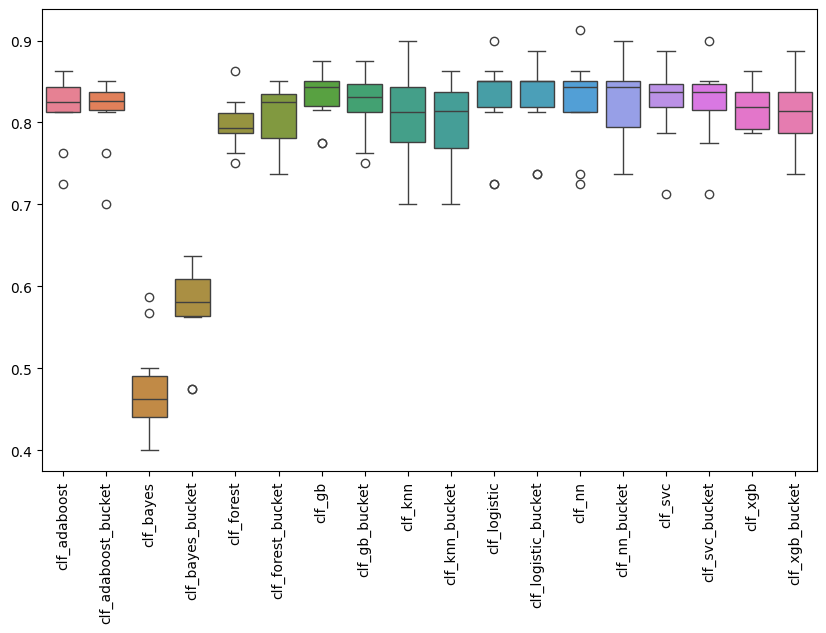

In [114]:
# sort dataframe base on model names
cv_scores_df = pd.DataFrame(cv_scores)
cv_scores_df = cv_scores_df.reindex(sorted(cv_scores_df.columns), axis=1)

plt.figure(figsize=(10, 6))
sns.boxplot(data=cv_scores_df)
plt.xticks(rotation=90)  
plt.show()

In [115]:
cv_scores_df.describe().sort_values(by='mean', axis=1, ascending=False)

,clf_gb,clf_logistic,clf_logistic_bucket,clf_nn,clf_svc,clf_svc_bucket,clf_nn_bucket,clf_gb_bucket,clf_xgb,clf_adaboost,clf_adaboost_bucket,clf_xgb_bucket,clf_knn,clf_forest_bucket,clf_knn_bucket,clf_forest,clf_bayes_bucket,clf_bayes
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.832731,0.826451,0.826435,0.825231,0.825201,0.823951,0.822731,0.821481,0.819012,0.816481,0.812716,0.811466,0.809028,0.808966,0.800231,0.797731,0.571790,0.476790
std,0.034318,0.057616,0.050257,0.056774,0.047204,0.050221,0.053576,0.039058,0.027478,0.043305,0.046840,0.047746,0.058770,0.038769,0.050070,0.031753,0.056468,0.059077
min,0.775000,0.725000,0.737500,0.725000,0.712500,0.712500,0.737500,0.750000,0.787500,0.725000,0.700000,0.737500,0.700000,0.737500,0.700000,0.750000,0.475000,0.400000
25%,0.820486,0.819252,0.818750,0.813079,0.818750,0.815625,0.794329,0.813079,0.792593,0.813079,0.815625,0.787500,0.775694,0.781250,0.768750,0.787500,0.563850,0.440625
50%,0.843750,0.850000,0.850000,0.843750,0.837500,0.837500,0.843750,0.831250,0.818750,0.825000,0.826080,0.813580,0.812500,0.825000,0.813657,0.793750,0.581250,0.462500
75%,0.850000,0.850000,0.850000,0.850000,0.847377,0.847377,0.850000,0.846875,0.837500,0.843750,0.837500,0.837500,0.843750,0.834915,0.837500,0.811111,0.609375,0.490625
max,0.875000,0.900000,0.887500,0.912500,0.887500,0.900000,0.900000,0.875000,0.862500,0.862500,0.850000,0.887500,0.900000,0.850000,0.862500,0.862500,0.637500,0.587500


In [118]:
cv_scores_df.describe().sort_values(by='50%', axis=1, ascending=False)

,clf_logistic,clf_logistic_bucket,clf_nn,clf_gb,clf_nn_bucket,clf_svc_bucket,clf_svc,clf_gb_bucket,clf_adaboost_bucket,clf_adaboost,clf_forest_bucket,clf_xgb,clf_knn_bucket,clf_xgb_bucket,clf_knn,clf_forest,clf_bayes_bucket,clf_bayes
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.826451,0.826435,0.825231,0.832731,0.822731,0.823951,0.825201,0.821481,0.812716,0.816481,0.808966,0.819012,0.800231,0.811466,0.809028,0.797731,0.571790,0.476790
std,0.057616,0.050257,0.056774,0.034318,0.053576,0.050221,0.047204,0.039058,0.046840,0.043305,0.038769,0.027478,0.050070,0.047746,0.058770,0.031753,0.056468,0.059077
min,0.725000,0.737500,0.725000,0.775000,0.737500,0.712500,0.712500,0.750000,0.700000,0.725000,0.737500,0.787500,0.700000,0.737500,0.700000,0.750000,0.475000,0.400000
25%,0.819252,0.818750,0.813079,0.820486,0.794329,0.815625,0.818750,0.813079,0.815625,0.813079,0.781250,0.792593,0.768750,0.787500,0.775694,0.787500,0.563850,0.440625
50%,0.850000,0.850000,0.843750,0.843750,0.843750,0.837500,0.837500,0.831250,0.826080,0.825000,0.825000,0.818750,0.813657,0.813580,0.812500,0.793750,0.581250,0.462500
75%,0.850000,0.850000,0.850000,0.850000,0.850000,0.847377,0.847377,0.846875,0.837500,0.843750,0.834915,0.837500,0.837500,0.837500,0.843750,0.811111,0.609375,0.490625
max,0.900000,0.887500,0.912500,0.875000,0.900000,0.900000,0.887500,0.875000,0.850000,0.862500,0.850000,0.862500,0.862500,0.887500,0.900000,0.862500,0.637500,0.587500


## __shortlist__ 
["clf_gb",	"clf_nn", "clf_logistic_bucket"]

In [120]:
cv_scores_df.describe()[["clf_gb",	"clf_nn", "clf_logistic", "clf_svc_bucket"]]

,clf_gb,clf_nn,clf_logistic,clf_svc_bucket
count,10.000000,10.000000,10.000000,10.000000
mean,0.832731,0.825231,0.826451,0.823951
std,0.034318,0.056774,0.057616,0.050221
min,0.775000,0.725000,0.725000,0.712500
25%,0.820486,0.813079,0.819252,0.815625
50%,0.843750,0.843750,0.850000,0.837500
75%,0.850000,0.850000,0.850000,0.847377
max,0.875000,0.912500,0.900000,0.900000


In [171]:
# let's analyze errors
shortlist_models_names = ["clf_gb",	"clf_nn", "clf_logistic", "clf_svc_bucket"]
shortlist_models = [GradientBoostingClassifier(), MLPClassifier(), LogisticRegression(), SVC()]

In [172]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, confusion_matrix

In [173]:
metric_names = ["Accuracy", "Precision", "Recall", "F1Score", "ROC_AUC", "ConfusionMatrix"]
metric_funcs = [accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix]

def get_mertric_result(y_true, y_pred):
    result = {}
    for i, name in enumerate(metric_names):
        result[name] = metric_funcs[i](y_true, y_pred)
    return result

get_mertric_result(y_train, y_train)

{'Accuracy': 1.0,
 'Precision': 1.0,
 'Recall': 1.0,
 'F1Score': 1.0,
 'ROC_AUC': 1.0,
 'ConfusionMatrix': array([[504,   0],
        [  0, 297]], dtype=int64)}

In [176]:
cv_results = []

for i, model in enumerate(shortlist_models):
    # choose which X you will use
    model_name = shortlist_models_names[i]
    X_ = X_train_bucket if "bucket" in model_name else X_train_nobucket
    
    # start predication    
    tick = time.time()
    print(f"=====\t Start {model_name} \t=====")

    y_pred_ = cross_val_predict(model, X_, y_train, cv = 10)
    if "svc" in model_name:
        y_pred_proba_ = cross_val_predict(model, X_, y_train, cv = 10, method="decision_function")
    else:
        y_pred_proba_ = cross_val_predict(model, X_, y_train, cv = 10, method="predict_proba")
    result = get_mertric_result(y_train, y_pred_)

    # store result
    result["Predication"] = y_pred_
    result["PredicationProbability"] = y_pred_proba_
    result["ModelName"] = model_name
    result["ContainBucket"] = True if "bucket" in model_name else False

    cv_results.append(result)
    print(f"=====\t time taken:\t {time.time() - tick}sec \t=====")
    

=====	 Start clf_gb 	=====
=====	 time taken:	 2.261836528778076sec 	=====
=====	 Start clf_nn 	=====


C:\Users\asusr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\asusr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\asusr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\asusr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

=====	 time taken:	 14.242558717727661sec 	=====
=====	 Start clf_logistic 	=====
=====	 time taken:	 0.31540393829345703sec 	=====
=====	 Start clf_svc_bucket 	=====
=====	 time taken:	 0.37225818634033203sec 	=====


In [177]:
cv_results_df = pd.DataFrame(cv_results)
cv_results_df = cv_results_df.set_index("ModelName")
cv_results_df

,Accuracy,Precision,Recall,F1Score,ROC_AUC,ConfusionMatrix,Predication,PredicationProbability,ContainBucket
ModelName,,,,,,,,,
clf_gb,0.832709,0.809886,0.717172,0.760714,0.808983,"[[454, 50], [84, 213]]","[0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, ...","[[0.9766714680779581, 0.023328531922041908], [...",False
clf_nn,0.825218,0.831224,0.663300,0.737828,0.791967,"[[464, 40], [100, 197]]","[0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, ...","[[0.9996224917991406, 0.0003775082008593214], ...",False
clf_logistic,0.826467,0.780142,0.740741,0.759931,0.808862,"[[442, 62], [77, 220]]","[0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, ...","[[0.9895493513687569, 0.010450648631243077], [...",False
clf_svc_bucket,0.823970,0.802326,0.696970,0.745946,0.797890,"[[453, 51], [90, 207]]","[0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, ...","[-1.1164355222433275, 0.08493702062892355, -1....",True


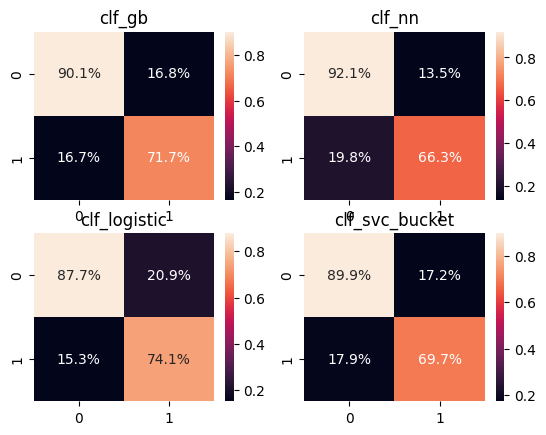

In [178]:
# plt.figure(figsize=(8, 6))
for i, row in enumerate(cv_results):
    plt.subplot(2, 2, i+1)
    conf_matrix = row['ConfusionMatrix']
    sns.heatmap(conf_matrix/np.sum(conf_matrix, axis=1), annot=True, fmt=".1%")
    plt.title(row['ModelName'])
    # plt.xlabel("Precited")
    # plt.ylabel("True")

- we know that most people didn't survive => we want the model to able to predict unsurvived people more => more focus TN we need low FN
- we need higher precision

In [168]:
from sklearn.metrics import precision_recall_curve

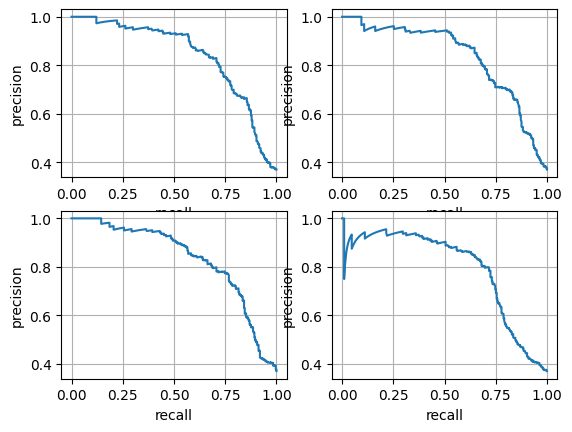

In [181]:
for i, row in enumerate(cv_results):
    plt.subplot(2, 2, i+1)
    y_pred_ = row["PredicationProbability"]
    if y_pred_.ndim > 1:
        y_pred_ = y_pred_[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_train, y_pred_)
    plt.plot(recall, precision)
    plt.xlabel("recall")
    plt.ylabel("precision")
    plt.grid()

plt.show()

they all bad make sense we didn't yet fine tunning

# Fine-Tune the System
i will fine tune all 4 models

## Save Model

In [209]:
import joblib

In [227]:
def save_model(model, model_name, X_, y_):
    save_model.lst_model_index +=  1
    # get result csv to save
    result = get_mertric_result(y_, model.predict(X_))
    result['ModelName'] = model_name
    result = pd.DataFrame([result])
    # create directory to save file
    model_path = f'models/{lst_model_index:04}_{model_name}'
    Path(model_path).mkdir(parents=True, exist_ok=True)
    # save model and result
    result.to_csv(model_path + "/result.csv")
    joblib.dump(model, model_path + "/model.joblib")
    # return result
    return result, model_path

save_model.lst_model_index = 0
    
def read_model(model_path):
    model = joblib.load(model_path + "/model.joblib")
    model_result = pd.read_csv(model_path + "/result.csv")

    return model, model_result

In [285]:
def make_submission(model_path, test_data, pipeline):
    model, _ = read_model(model_path)

    X_test = pipeline.transform(test_data)
    submission_df = pd.DataFrame(index=test_data.index)
    submission_df["Survived"] = model.predict(X_test)

    
    submission_df.to_csv(model_path + "/submission.csv")

## Gradient Boosting

In [183]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [182]:
shortlist_models_names = ["clf_gb",	"clf_nn", "clf_logistic", "clf_svc_bucket"]
shortlist_models = [GradientBoostingClassifier(), MLPClassifier(), LogisticRegression(), SVC()]

## GradientBoosting

In [276]:
# let's start with GB
paramerters_gb = {
    'n_estimators': np.arange(30, 251, 50),
    'learning_rate': np.linspace(0.01, 0.2, 10),
    'max_depth': np.arange(3, 6),
}

random_search = RandomizedSearchCV(GradientBoostingClassifier(), param_distributions=paramerters_gb, n_iter=10,
                                   cv=5, scoring='accuracy', random_state=42, n_jobs=-1).fit(X_train_nobucket, y_train)

In [277]:
clf_gb_bst = random_search.best_estimator_
pd.DataFrame([get_mertric_result(y_train, clf_gb_bst.predict(X_train_nobucket))])

,Accuracy,Precision,Recall,F1Score,ROC_AUC,ConfusionMatrix
0,0.878901,0.903475,0.764706,0.828319,0.8571,"[[470, 25], [72, 234]]"


In [278]:
random_search.best_score_

0.8327251552795032

In [280]:
# kinda overfit I see let's increase learning rate

In [281]:
save_model(clf_gb_bst, "GradientBoost_ACC_82", X_test_nobucket, y_test)

(   Accuracy  Precision    Recall   F1Score   ROC_AUC     ConfusionMatrix  \
 0  0.844444   0.805556  0.805556  0.805556  0.837963  [[47, 7], [7, 29]]   
 
               ModelName  
 0  GradientBoost_ACC_82  ,
 'models/0000_GradientBoost_ACC_82')

In [286]:
make_submission("models/0000_GradientBoost_ACC_82", test_data, pipeline_nobucket_base)

## NN

## SVC

In [303]:
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf','linear']}

grid = GridSearchCV(SVC() , param_grid, cv=5, scoring="accuracy").fit(X_train_nobucket, y_train)

In [304]:
clf_svc_bst = grid.best_estimator_

print("Train Results")
pd.DataFrame([get_mertric_result(y_train, clf_svc_bst.predict(X_train_nobucket))])

Train Results


,Accuracy,Precision,Recall,F1Score,ROC_AUC,ConfusionMatrix
0,0.837703,0.835878,0.715686,0.771127,0.814409,"[[452, 43], [87, 219]]"


In [305]:
print("Validation Accuracy")
grid.best_score_

Validation Accuracy


0.8339518633540373

In [306]:
print("Test Results")
pd.DataFrame([get_mertric_result(y_test, clf_svc_bst.predict(X_test_nobucket))])

Test Results


,Accuracy,Precision,Recall,F1Score,ROC_AUC,ConfusionMatrix
0,0.833333,0.783784,0.805556,0.794521,0.828704,"[[46, 8], [7, 29]]"


In [307]:
# at least there's no overfitting

In [308]:
save_model(clf_svc_bst, "SVC_NOBUCK_ACC_83", X_test_nobucket, y_test)

(   Accuracy  Precision    Recall   F1Score   ROC_AUC     ConfusionMatrix  \
 0  0.833333   0.783784  0.805556  0.794521  0.828704  [[46, 8], [7, 29]]   
 
            ModelName  
 0  SVC_NOBUCK_ACC_83  ,
 'models/0000_SVC_NOBUCK_ACC_83')

In [310]:
make_submission("models/0000_SVC_NOBUCK_ACC_83", test_data, pipeline_nobucket_base)


In [ ]:
# so SVC actually did very will with 